**Installing libraries**

In [1]:
!pip install livelossplot
!pip install hazm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394489 sha256=79c53c9178bc2335f61637f6ba4955b605da29eb64838133e5c2aecd72353fb0
  Stored in directory: /root/.cache/pip/wheels/ac/62/f6/88933dadcd64a1614894614aa68cf57c4b8e5256acb650b1f1
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp39-cp39-linux_x86_64.whl size=180364 sha256=4eb27a99dc6f08275ee703eb78ba8f1ae83f80f7b981c33390417ced8848f61a
  Stored in directory: /root/.cache/pip/wheels/8e/ff/82/932

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
np.random.seed(0)
plt.style.use("ggplot")
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.11.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Connecting to google drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loader class, which is used for load and preprocessing data**

For using this object, you should change path of data

In [4]:
import codecs
import math
from os import listdir
from os.path import isfile, join

import numpy as np
import tqdm
import torch
from hazm import *
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import normalize

class Loader:
    path_data = '/content/drive/My Drive/NLP-Project/samples.out.txt'
    start_tag_list = ['<c>', '<m>', '<e>']
    end_tag_list = ['</c>', '</m>', '</e>']
    none_tag = '<none>'

    def __init__(self):
        self.normalizer = Normalizer()
        self.lemmatizer = Lemmatizer()

    def create_data_label(self):
        lines = codecs.open(self.path_data, 'r', 'utf-8').readlines()

        sent_token_list = []
        sent_label_list = []
        for sent in lines:
            sent = self.normalizer.normalize(sent)
            token_list = []
            label_list = []
            last_tag = self.none_tag
            for token in word_tokenize(sent):
                if token in self.start_tag_list:
                    last_tag = token
                    continue
                if token in self.end_tag_list:
                    last_tag = self.none_tag
                    continue

                token_list.append(self.lemmatizer.lemmatize(token))
                label_list.append(last_tag)

            sent_token_list.append(token_list)
            sent_label_list.append(label_list)
        return sent_token_list, sent_label_list


loader = Loader()
sent_token_list, sent_label_list = loader.create_data_label()

**Sentence_word_tag_Getter class, which is used to produce the shape of data needed for model**

In [5]:
class Sentence_word_tag_Getter:
    def __init__(self, sent_token_list, sent_label_list):
        self.sent_token_list = sent_token_list
        self.sent_label_list = sent_label_list
        
    def sent_maker(self):
      sents = []
      for i in range (len(self.sent_token_list)):
          sents.append([])
          for j in range (len(self.sent_label_list[i])):
            sents[i].append((self.sent_token_list[i][j],self.sent_label_list[i][j]))
      return sents

    def words_maker(self):
      words = []
      for i in range(len(self.sent_token_list)):
        for word in self.sent_token_list[i]:
          words.append(word)  
      
      words = list(set(words))
      words.append("ENDPAD")
      num_words = len(words)

      return words, num_words

    def tag_maker(self):
      tags = []
      for i in range(len(self.sent_token_list)):
        for tag in self.sent_label_list[i]:
          tags.append(tag)

      tags = list(set(tags))
      num_tags = len(tags)
      
      return tags, num_tags

In [6]:
getter = Sentence_word_tag_Getter(sent_token_list,sent_label_list)
sentences = getter.sent_maker()
words, num_words = getter.words_maker()
tags, num_tags = getter.tag_maker()

**Making word2idx and tag2idx in order to indexing words and tags**

In [7]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

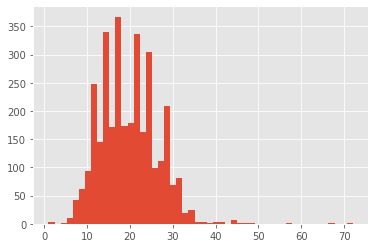

In [8]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

**Making Dataset**

In [9]:
max_len = 40

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["<none>"])

**Splitting Dataset**

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

**Create and compile and train the main Model**

In [11]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 50)            370900    
                                                                 
 spatial_dropout1d (SpatialD  (None, 40, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 40, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 40, 4)            804       
 ibuted)                                                         
                                                             

In [12]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

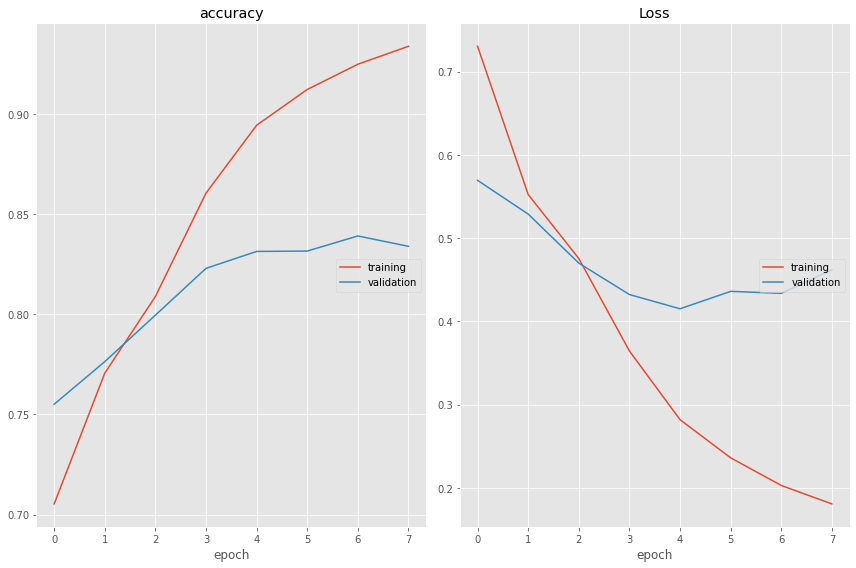

accuracy
	training         	 (min:    0.705, max:    0.934, cur:    0.934)
	validation       	 (min:    0.755, max:    0.839, cur:    0.834)
Loss
	training         	 (min:    0.181, max:    0.730, cur:    0.181)
	validation       	 (min:    0.415, max:    0.569, cur:    0.462)

Epoch 8: val_loss did not improve from 0.41509
83/83 [==============================] - 29s 354ms/step - loss: 0.1808 - accuracy: 0.9338 - val_loss: 0.4619 - val_accuracy: 0.8339
CPU times: user 5min 12s, sys: 34.6 s, total: 5min 46s
Wall time: 4min 16s


In [13]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

**Evaluate and save the model**

In [14]:
model.evaluate(x_test, y_test)

21/21 [==============================] - 1s 25ms/step - loss: 0.4619 - accuracy: 0.8339


[0.461917906999588, 0.8339040875434875]

In [15]:
model.save('/content/drive/My Drive/NLP-Project/Cause_Effect_Detection_NER.h5')

**Showing an example output of model**

In [16]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 407ms/step
Word           True 	 Pred

------------------------------
اجرا           <c>	<c>
موافقتنامه‌های <c>	<c>
تجار           <c>	<c>
و              <c>	<c>
حمایت          <c>	<c>
از             <c>	<c>
نیرو           <c>	<c>
کار            <c>	<c>
توانست#توان    <none>	<none>
تأثیر          <m>	<m>
بسزایی         <m>	<m>
در             <m>	<m>
ارتقا          <e>	<e>
ثبات           <e>	<e>
و              <e>	<e>
امنیت          <e>	<e>
اقتصاد         <e>	<e>
بیشتر          <e>	<e>
در             <e>	<e>
کشور           <e>	<e>
مبدا           <e>	<e>
مهاجرت         <e>	<e>
داشت#دار       <none>	<none>
.              <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>
رومانی         <none>	<none>